<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/master/notebooks/2d_cnn_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MicroResNet

<div style="text-align: right"> Bere et Richardt </div>

En este ejemplo realizaremos implementación muy reducida del bloque ResNet. Emplearemos una versión reducida de Recipes5k, para resolver una tarea de clasificación binara que consiste en aprender para predecir si la comida en la imagen en la es saludable o no.

![recipes](../figs/recipes5k.jpg)

## 1 Preparación

### 1.1 Bibliotecas

In [ ]:
# Colab
!pip install torch-summary

In [1]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
import os

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvutils
# imágenes
from skimage import io
from skimage.transform import resize
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
# inspección de arquitectura
# https://github.com/TylerYep/torch-summary
from torchsummary import summary
# barras de progreso
from tqdm import tqdm
# imágenes
from PIL import Image


# directorio de datos
DATA_DIR = '../data'
file_id = '1V83QXOX1ArJrx--0jjJUjV-UNp_dG3xO'
filename = 'recipes2k.tar.gz'

# tamaño del lote
BATCH_SIZE = 128
# tamaño de la imagen
IMG_SIZE = 64

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
def display_grid(xs, titles, rows, cols, figsize=(8, 6)):
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()

def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x

## 2 Datos

### 2.1 Tuberias de datos con PyTorch

<img src="../figs/comida_datos.svg" width="950" height="750">

### 2.2 Descarga de Recipes2k

In [3]:
file_path = os.path.join(DATA_DIR, filename)
# si no existe, descargamos
if not os.path.isfile(file_path):
    # descarga de Drive
    tvutils.download_file_from_google_drive(
        file_id, 
        DATA_DIR, 
        filename=filename
    )
    # Descomprimimos el archivo
    tvutils.extract_archive(file_path)
    print('Datos descargados')
else:
    print('Datos ya descargados')

Datos ya descargados


### 2.3 Conjunto de datos

In [4]:
class RecipesDS:
    
    def __init__(self, root, tsfm=None):
        df = pd.read_csv(os.path.join(root, 'trn.csv'), index_col='item')
        df = df['healthy']

        self.paths = []
        self.labels = []
        base_dir = os.path.join(root, 'trn')
        classes = sorted(os.listdir(base_dir))
        for clazz in classes:
            class_dir = os.path.join(base_dir, clazz)
            names = sorted(os.listdir(class_dir))
            for name in names:
                self.paths.append(os.path.join(class_dir, name))
                self.labels.append(df.loc[clazz])
        self.tsfm = tsfm
        
        
    def __getitem__(self, i):
        path = self.paths[i]
        x = Image.open(path)
        if self.tsfm is not None:
            x = self.tsfm(x)
        y = np.array(self.labels[i], np.float32)
        return x, y
    
    def __len__(self):
        return len(self.paths)

### 2.4 Exploración

x shape=torch.Size([12, 64, 64, 3]) dtype=torch.uint8
y shape=torch.Size([12]) dtype=torch.float32


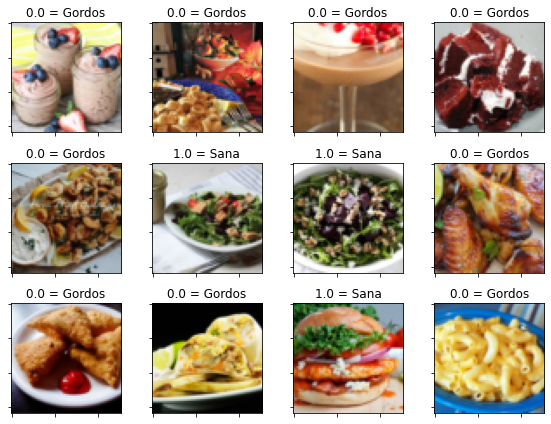

In [5]:
tsfm = transforms.Compose([
    # recortamos al centro
    transforms.CenterCrop(240),
    # redimensionamos
    transforms.Resize(IMG_SIZE),
    # convertimos a ndarray
    np.array
])

base_dir = os.path.join(DATA_DIR, 'recipes2k')
ds = RecipesDS(base_dir, tsfm)

dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=12,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
for x, y in take(dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')
    titles = [f'{l} = Sana' if l else f'{l} = Gordos' for l in y]
    display_grid(x, titles, 3, 4)

### 2.3 Cargador de datos

In [6]:
tsfm = transforms.Compose([
    # recortamos al centro
    transforms.CenterCrop(240),
    # redimensionamos a 100x100 
    transforms.Resize(IMG_SIZE),
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
])

base_dir = os.path.join(DATA_DIR, 'recipes2k')
trn_ds = RecipesDS(base_dir, tsfm)

trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=12,
    # desordenar
    shuffle=True
)

# imprimimos forma y tipo del lote
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([12, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([12]) dtype=torch.float32


## 3 Modelo

<!-- ![arch](https://raw.githubusercontent.com/richardtml/riiaa-20-aa/master/media/fc.jpg) -->

### 3.1 Definición de bloque ResNet

<img src="../figs/resnetblock_complete.svg" width="550" height="350">

In [7]:
class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        out_channels1, out_channels2 = out_channels

        # [N, I, H, W] => [N, O2, H, W]
        self.cnn_block = nn.Sequential(
            # conv1
            # [N, I, H, W] => [N, O1, H, W
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=out_channels1, 
                      kernel_size=3, padding=1),
            # [N, O1, H, W]
            nn.BatchNorm2d(out_channels1),
            # [N, O1, H, W]
            nn.ReLU(),
            
            # conv2
            # [N, O1, H, W] => [N, O2, H, W]
            nn.Conv2d(in_channels=out_channels1, 
                      out_channels=out_channels2,
                      kernel_size=3, padding=1),
            # [N, O2, H, W]
            nn.BatchNorm2d(out_channels2),
            # [N, O2, H, W]
            nn.ReLU(),
        )
        
        # [N, I, H, W] => [N, O2, H, W]
        self.conv1x1 = nn.Conv2d(in_channels=in_channels, 
                                 out_channels=out_channels2, 
                                 kernel_size=1)

    def forward(self, x):
        # [N, I, H, W] => [N, O2, H, W]
        x1 = self.cnn_block(x)
        # [N, I, H, W] => [N, O2, H, W]
        x2 = self.conv1x1(x)
        # [N, O2, H, W]
        x = x1 + x2
        return x


### 3.1 Definición de la arquitectura

In [8]:
class MicroResNet(nn.Module):

    def __init__(self):
        super(MicroResNet, self).__init__()
        self.num_feats = 16 * 16 * 16
        
        # [N, 3, 64, 64] => [N, 16, 16, 16]
        self.cnn = nn.Sequential(
            # [N, 3, 64, 64] => [N, 8, 64, 64]
            ResBlock(in_channels=3, out_channels=(4, 8)),
            # [N, 8, 64, 64] => [N, 8, 32, 32]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 8, 32, 32] => [N, 16, 32, 32]
            ResBlock(in_channels=8, out_channels=(12, 16)),
            # [N, 16, 32, 32] => [N, 16, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # [N, 16, 16, 16] => [N, 16x16x16]
        self.flatten = nn.Flatten()

        # [N, 16x16x16] => [N, 1]
        self.cls = nn.Linear(self.num_feats, 1)

    def forward(self, x):
        # [N, 3, 64, 64] => [N, 16, 16, 16]
        x = self.cnn(x)
        # [N, 16, 16, 16] => [N, 16x16x16]
        x = self.flatten(x)
        # [N, 16x16x16] => [N, 1]
        x = torch.sigmoid(self.cls(x))
        return x

### 3.2 Inspección de la arquitectura

In [9]:
model = MicroResNet()
summary(model, (3, 64, 64), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 16, 16]          --
|    └─ResBlock: 2-1                     [-1, 8, 64, 64]           --
|    |    └─Sequential: 3-1              [-1, 8, 64, 64]           432
|    |    └─Conv2d: 3-2                  [-1, 8, 64, 64]           32
|    └─MaxPool2d: 2-2                    [-1, 8, 32, 32]           --
|    └─ResBlock: 2-3                     [-1, 16, 32, 32]          --
|    |    └─Sequential: 3-3              [-1, 16, 32, 32]          2,676
|    |    └─Conv2d: 3-4                  [-1, 16, 32, 32]          144
|    └─MaxPool2d: 2-4                    [-1, 16, 16, 16]          --
├─Flatten: 1-2                           [-1, 4096]                --
├─Linear: 1-3                            [-1, 1]                   4,097
Total params: 7,381
Trainable params: 7,381
Non-trainable params: 0
Total mult-adds (M): 4.52
Input size (MB): 0.05
Forward/backward pass size (MB)

### 3.3 Prueba de la arquitectura

In [10]:
# inferencia con datos sinteticos
x = torch.zeros(1, 3, 64, 64)
y = model(x)
print(y.shape)

torch.Size([1, 1])


## 4 Entrenamiento

<img src="../figs/comida_entrenamiento.svg" width="650" height="450">

### 4.1 Ciclo de entrenamiento

In [14]:
# creamos un modelo
model = MicroResNet()

# optimizador
opt = optim.SGD(model.parameters(), lr=1e-3)

# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 5
for epoch in range(EPOCHS):
    
    # modelo en modo de entrenamiento
    model.train()
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_prob = model(x)
        # calculamos la pérdida
        y_prob = y_prob.squeeze()
        loss = F.binary_cross_entropy(y_prob, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # modelo en modo de evaluación
    model.eval()    
    
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in trn_dl:
            # hacemos inferencia para obtener los logits
            y_prob = model(x)
            y_prob = y_prob.squeeze()
            # obtenemos la clase predicha
            y_pred = torch.round(y_prob)
            # calculamos la pérdida
            loss = F.binary_cross_entropy(y_prob, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
        
        # agregagmos al historial de pérdidas
        loss_hist.append(loss)

E 0 loss= 51.37 acc=78.36
E 1 loss= 49.59 acc=78.53
E 2 loss= 48.51 acc=79.15
E 3 loss= 47.73 acc=78.93
E 4 loss= 47.27 acc=79.22


## 5. Probando la vitamina T

In [15]:
# cargamos imágenes de prueba
imgs = []
tst_dir = os.path.join(base_dir, 'tst')
names = sorted(os.listdir(tst_dir))
for name in names:
    path = os.path.join(tst_dir, name)
    img = io.imread(path)
    size = min(*img.shape[:2])
    img = crop_center(img, size, size)
    img = resize(img, (IMG_SIZE, IMG_SIZE))
    imgs.append(img)

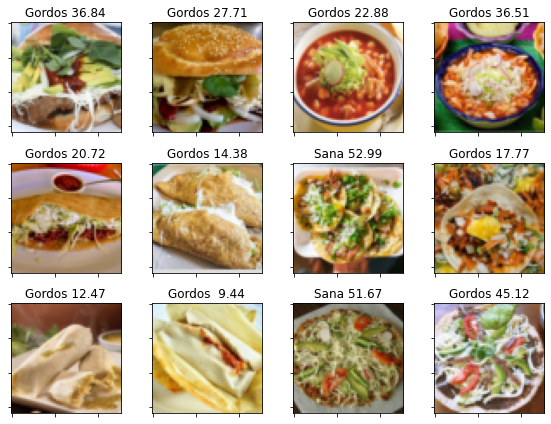

In [16]:
# desplegamos con probas
titles = []
with torch.no_grad():
    for img in imgs:
        img_torch = numpy_to_torch(img)
        img_torch = img_torch.unsqueeze(0)
        prob = model(img_torch)
        prob = prob.item() * 100
        if prob < 50:
            titles.append(f'Gordos {prob:5.2f}')
        else:
            titles.append(f'Sana {prob:5.2f}')

display_grid(imgs, titles, 3, 4)